In [2]:
import os
from os import listdir
from os.path import isfile, join

import pandas as pd
from itertools import islice
import numpy as np

from skimage.external import tifffile
from skimage.external.tifffile import imread

import matplotlib.pyplot as plt

import ipywidgets as widgets

import random

In [5]:
bigDir = r'S:\CookLab\Liu\20190816_organizedData_MCM_loading\DATA'
cellDataFile=r'S:\CookLab\Liu\20190816_organizedData_MCM_loading\sel_cells_v4.csv'

het_percentile=20

In [6]:
cellData=pd.read_csv(cellDataFile)
cellData.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,file,original cell name,Amy_mod,movie,x,y,...,hetChrom_manual_ch3,Slice,hetChrom_5_volume,hetChrom_5perc_ch1,hetChrom_5perc_ch2,hetChrom_5perc_ch3,hetChrom_10_volume,hetChrom_10perc_ch1,hetChrom_10perc_ch2,hetChrom_10perc_ch3
0,0,0,0,0,20190625_cell-00.czi,7LE1(B),1130/10,190619-cdc6-dhb-pcna002xy09,172.0,956.0,...,4.143086e+08,990.0,23002.0,364188887.0,88317208.0,6.932780e+08,46007.0,6.367809e+08,174113816.0,1.352609e+09
1,1,1,1,1,20190625_cell-01.czi,7L-E1(T),0,190619-cdc6-dhb-pcna002xy09,158.0,906.0,...,4.146000e+08,861.0,21909.0,334668123.0,81681486.0,6.958492e+08,43776.0,5.863799e+08,162477177.0,1.353567e+09
2,2,2,2,2,20190625_cell-02.czi,7L-E2(B),0,190619-cdc6-dhb-pcna002xy09,832.0,252.0,...,7.771410e+08,1275.0,19915.0,394904506.0,99242809.0,7.051818e+08,39819.0,6.929880e+08,194653300.0,1.366969e+09
3,3,3,3,3,20190625_cell-03.czi,7L-E2(T),0,190619-cdc6-dhb-pcna002xy09,888.0,160.0,...,3.506479e+08,820.0,21224.0,370485963.0,101486816.0,6.664035e+08,42351.0,6.475195e+08,195411924.0,1.299178e+09
4,4,4,4,5,20190625_cell-05.czi,7L-G2,0,190619-cdc6-dhb-pcna002xy09,172.0,324.0,...,1.218426e+09,946.0,40718.0,863171908.0,126935948.0,1.304929e+09,81455.0,1.506693e+09,248569626.0,2.584108e+09


## Segment

In [67]:
i=257


# Progress Bar
progBar=widgets.IntProgress(
    value=i,
    min=0,
    max=len(cellData),
    step=1,
    description='Progress:',
    orientation='horizontal'
)
display(progBar)

for i,myCell in islice(cellData.iterrows(), i,None):

    # create folder to store this percentile data if it doesn't exist yet
    newSegFolder = os.path.dirname(myCell.path).replace('data_tiff',f'segmentation_random_{het_percentile}')

    try:
        os.mkdir(newSegFolder)
    except:
        pass

    # changing the drive setting
    cellPath=myCell.path
    #cellPath=cellPath.replace('S:','Z:')
    print(cellPath)
    # open tiff image of a cell
    myImage=imread(cellPath)    
    print(myImage.dtype)
    myChannel = myImage[:, 0, :, :] #1st channel is hetChrom (as stained by HP1B or H3K9Me3)
    print(np.sum(myImage))
    # open nucleus mask
    nucleusMaskPath=cellPath
    nucleusMaskPath=nucleusMaskPath.replace('data_tiff','segmentation_nucleus_Otsu')
    nucleusMaskPath=nucleusMaskPath.replace('.tif','_nucleus.tif')
    nucleusMask=imread(nucleusMaskPath)

    # make nucleus mask binary
    nucleusMask = nucleusMask.astype(bool)

    # clean image
    myNucleus = myChannel[nucleusMask]
   
    # find threshold
    myPercentile = np.nanpercentile(myNucleus, (100-het_percentile)) 
    
    #find 20% random sample ...?
    #don't think this makes much sense if we are going to make threshold out of this 'percentile'
    #myPercentile=random.sample(list(myNucleus),k=int(len(myNucleus)*.2))
    #print(myPercentile)

    # threshold
    myHetMask=np.zeros(myChannel.shape).astype('bool')
    myHetMask[myChannel >= myPercentile] = 1
    
    cleanNucleusMask=~nucleusMask
    myHetMask[cleanNucleusMask]=0
    cleanHetMask = ~myHetMask
    
    # save segmentation mask
    #maskFile = os.path.basename(myCell.path).replace('.tif',f'_hetChrom.tif')
    #tifffile.imsave(os.path.join(newSegFolder,maskFile), myHetMask.astype('uint8'))

    # calculate signals
    df = pd.DataFrame(columns = ['HetChrom_Volume','HetChrom_total_ch1','HetChrom_total_ch2','HetChrom_total_ch3',
                                 'Slice'])

    df.Slice = range(myChannel.shape[0])
    df.HetChrom_Volume =  myHetMask.sum(-1).sum(-1)
    
    for ch in range(3):
 
        myChannel[cleanHetMask] = 0
        signal = myChannel.sum(-1).sum(-1)
        exec(f'df.HetChrom_total_ch{ch}_random20=signal')

    # save signals
    #dfSavePath=myCell.path
    #dfSavePath=dfSavePath.replace('data_tiff','results')
    #dfSavePath=dfSavePath.replace('.tif',f'_hetChrom_{str((het_percentile))}.csv')
    #df.to_csv(dfSavePath)

    # add info to cell info file
    cellData.loc[i,f'hetChrom_{str(het_percentile)}_volume']=np.sum(df.HetChrom_Volume)
    for ch in range(3):
        exec(f"cellData.loc[i,'hetChrom_random{str(het_percentile)}perc_ch{ch+1}']=np.sum(df.HetChrom_total_ch{ch}_random20)") 
    break
    progBar.value=progBar.value+1

IntProgress(value=257, description='Progress:', max=300)

S:\CookLab\Liu\20190816_organizedData_MCM_loading\DATA\20190712-MSL decon rename\data_tiff\201907012_cellde-04.ciz.tif
float32
36014735000.0


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [68]:
print(np.sum(myImage))

24476637000.0


In [69]:
print(myImage.shape)
print(np.sum(myHetMask))
print(myHetMask.shape)
print(nucleusMask.sum())
print(nucleusMask.shape)
print(myHetMask.sum(-1).sum(-1))
print(np.sum(myHetMask.sum(-1).sum(-1)))
print(myPercentile)

(34, 3, 380, 380)
57228
(34, 380, 380)
286138
(34, 380, 380)
[   0    0    0    0    0    0    0    0    0  774 2422 4027 5044 5333
 5377 5553 5652 5586 5061 4295 3369 2363 1394  588  240  100   39   11
    0    0    0    0    0    0]
57228
7858.27099609375


In [56]:
np.sum(df.HetChrom_Volume)

86355

In [57]:
cellPath

'S:\\CookLab\\Liu\\20190816_organizedData_MCM_loading\\DATA\\20190712-MSL decon rename\\data_tiff\\201907012_cellde-04.ciz.tif'

In [58]:
myChannel = myImage[:, 0, :, :] #1st channel is hetChrom (as stained by HP1B or H3K9Me3)

# open nucleus mask
nucleusMaskPath=cellPath
nucleusMaskPath=nucleusMaskPath.replace('data_tiff','segmentation_nucleus_Otsu')
nucleusMaskPath=nucleusMaskPath.replace('.tif','_nucleus.tif')
nucleusMask=imread(nucleusMaskPath)

# make nucleus mask binary
nucleusMask = nucleusMask.astype(bool)

# clean image
myNucleus = myChannel[nucleusMask]

# find threshold
myPercentile = np.nanpercentile(myNucleus, (100-het_percentile)) 

#find 20% random sample ...?
#don't think this makes much sense if we are going to make threshold out of this 'percentile'
#myPercentile=random.sample(list(myNucleus),k=int(len(myNucleus)*.2))
#print(myPercentile)

# threshold
myHetMask=np.zeros(myChannel.shape).astype('bool')
myHetMask[myChannel >= myPercentile] = 1

print(myHetMask.sum())
print(np.sum(myHetMask))

57228
57228


In [59]:
myChannel.shape

(34, 380, 380)

In [60]:
np.sum(myChannel)

571808100.0

In [52]:
print(myImage.shape)
print(np.sum(myHetMask))
print(myHetMask.shape)
print(nucleusMask.sum())
print(nucleusMask.shape)
print(myHetMask.sum(-1).sum(-1))
print(np.sum(myHetMask.sum(-1).sum(-1)))
print(myPercentile)

(34, 3, 380, 380)
57228
(34, 380, 380)
286138
(34, 380, 380)
[   0    0    0    0    0    0    0    0    0  774 2422 4027 5044 5333
 5377 5553 5652 5586 5061 4295 3369 2363 1394  588  240  100   39   11
    0    0    0    0    0    0]
57228
4714.974902389491


In [19]:
# changing the drive setting
cellPath=myCell.path
print(cellPath)
# open tiff image of a cell
myImage=imread(cellPath)    
myChannel = myImage[:, 0, :, :] #1st channel is hetChrom (as stained by HP1B or H3K9Me3)

# open nucleus mask
nucleusMaskPath=cellPath
nucleusMaskPath=nucleusMaskPath.replace('data_tiff','segmentation_nucleus_Otsu')
nucleusMaskPath=nucleusMaskPath.replace('.tif','_nucleus.tif')
nucleusMask=imread(nucleusMaskPath)

# make nucleus mask binary
nucleusMask = nucleusMask.astype(bool)

# clean image
myNucleus = myChannel[nucleusMask]

# find threshold
myPercentile = np.nanpercentile(myNucleus, (100-het_percentile)) 

#find 20% random sample ...?
#don't think this makes much sense if we are going to make threshold out of this 'percentile'
#myPercentile=random.sample(list(myNucleus),k=int(len(myNucleus)*.2))
#print(myPercentile)

# threshold
myHetMask=np.zeros(myChannel.shape).astype('bool')
myHetMask[myChannel >= myPercentile] = 1

print(myHetMask.sum())
    

S:\CookLab\Liu\20190816_organizedData_MCM_loading\DATA\20190712-MSL decon rename\data_tiff\201907012_cellde-04.ciz.tif
86355


In [27]:
myImage.shape

(34, 3, 380, 380)

In [20]:
myCell.path

'S:\\CookLab\\Liu\\20190816_organizedData_MCM_loading\\DATA\\20190712-MSL decon rename\\data_tiff\\201907012_cellde-04.ciz.tif'

In [74]:
nucleusMask.sum()

286138

In [13]:
cellData.to_csv(cellDataFile.replace('v4','v5'))

In [70]:
myCell=cellData.loc[257,:]
myCell

Unnamed: 0                                           257
Unnamed: 0.1                                         257
Unnamed: 0.1.1                                       257
Unnamed: 0.1.1.1                                     328
file                         201907012_cellde-04.ciz.ims
original cell name                         15-BK-E1L-63X
Amy_mod                                                0
movie                              19-07-08 pcna dhbxy15
x                                                     38
y                                                    384
ab1 (heterochromatin)                               HP1B
ab1 ch                                                 1
ab2 (MCM)                                           MCM3
ab2 ch                                                 2
DAPI ch                                                3
DIC ch                                               NaN
category                                         earlyG1
physical age [min]             

In [71]:
myCell.hetChrom_20_volume/myCell.nucleus_Otsu_volume

0.30179493810678765

<IPython.core.display.Javascript object>


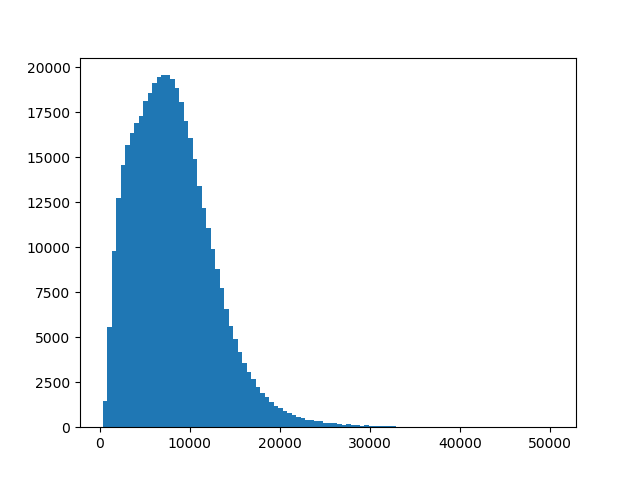

In [50]:
%matplotlib notebook
h=plt.hist(myNucleus,bins=100)

In [55]:
myPercentile = np.nanpercentile(myNucleus, (100-het_percentile+1)) 
myPercentile

11877.0

In [56]:
np.sum(myNucleus>myPercentile)/len(myNucleus)

0.18995429424672003

In [65]:
hetPercentile

NameError: name 'hetPercentile' is not defined

In [59]:
myCell

Unnamed: 0                                         257
Unnamed: 0.1                                       257
Unnamed: 0.1.1                                     257
Unnamed: 0.1.1.1                                   328
file                       201907012_cellde-04.ciz.ims
original cell name                       15-BK-E1L-63X
Amy_mod                                              0
movie                            19-07-08 pcna dhbxy15
x                                                   38
y                                                  384
ab1 (heterochromatin)                             HP1B
ab1 ch                                               1
ab2 (MCM)                                         MCM3
ab2 ch                                               2
DAPI ch                                              3
DIC ch                                             NaN
category                                       earlyG1
physical age [min]                                telo
molecular 

<IPython.core.display.Javascript object>


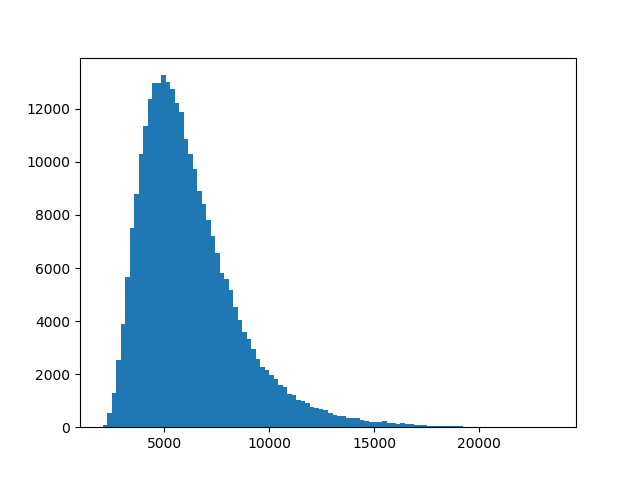

In [60]:
%matplotlib notebook
h=plt.hist(myNucleus,bins=100)

In [61]:
myPercentile

7858.27099609375

In [62]:
np.sum(myNucleus==myPercentile)

0

In [64]:
np.sum(myNucleus>=myPercentile)/len(myNucleus)

0.20000139792687444